In [36]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape, X_display.shape)
X.head()

(9932, 18) (9932, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [4]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model_train

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:7.26934
[999]	test-cox-nloglik:6.55579


In [5]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 1000, evals = [(xgb_full, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:8.88081
[999]	test-cox-nloglik:8.16748


In [6]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8289463410825477

# flat graph

In [52]:
def build_graph(model, X, display_translator={}, target_name='prediction'):
    '''
    build and return a graph (list of nodes), to be runnable in main
    model: xgboost model
    X: background distribution (n, d) dataframe object
    x: target samples to be explained (n2, d)
    names: the feature names of the d dimensional features
    display_translator: translate features values to readable format, see flow.py:translator
    '''
    # build the graph
    names = X.columns
    nodes = [Node(name) for name in names]
    nodes.append(Node(target_name, 
                      lambda *args: model.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((name, args[i]) for i, name in enumerate(names))))),
                      nodes, is_target_node=True))
    
    graph = Graph(nodes, display_translator=display_translator)
    return graph
    
nsamples = 1000
graph = build_graph(model, X, translator(X.columns, X, X_display), 'predicted hazard')
explainer = GraphExplainer(graph, X, nruns=100) 
cf = explainer.shap_values(X[:nsamples])


sampling: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


In [19]:
bg = shap.utils.sample(X, 100)
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), bg)
shap_values = explainer(X[:100])


Permutation explainer: 100%|██████████| 100/100 [00:27<00:00,  3.12it/s]
Permutation explainer: 101it [00:27,  3.65it/s]                         


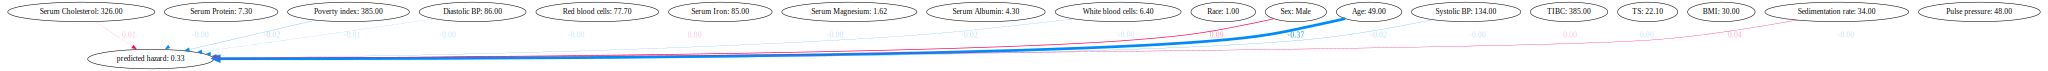

In [53]:
sample_ind = 8
cf.draw(sample_ind)

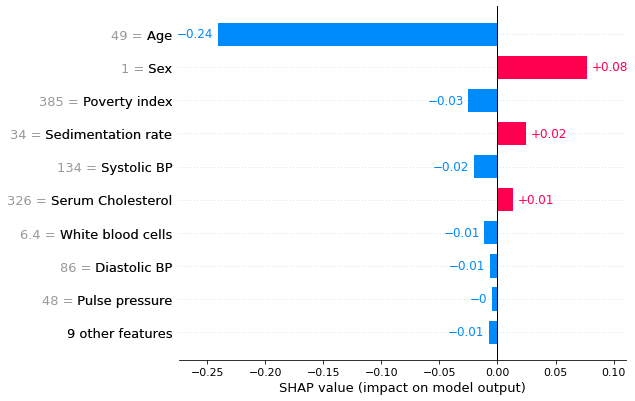

In [21]:
shap.plots.bar(shap_values[sample_ind])

In [17]:
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))

Age                    49.000000
Diastolic BP           86.000000
Poverty index         385.000000
Race                    1.000000
Red blood cells        77.700000
Sedimentation rate     34.000000
Serum Albumin           4.300000
Serum Cholesterol     326.000000
Serum Iron             85.000000
Serum Magnesium         1.620000
Serum Protein           7.300000
Sex                     1.000000
Systolic BP           134.000000
TIBC                  385.000000
TS                     22.100000
White blood cells       6.400000
BMI                    30.004222
Pulse pressure         48.000000
Name: 8, dtype: float64
target: [0.3340421]


# cluster graph

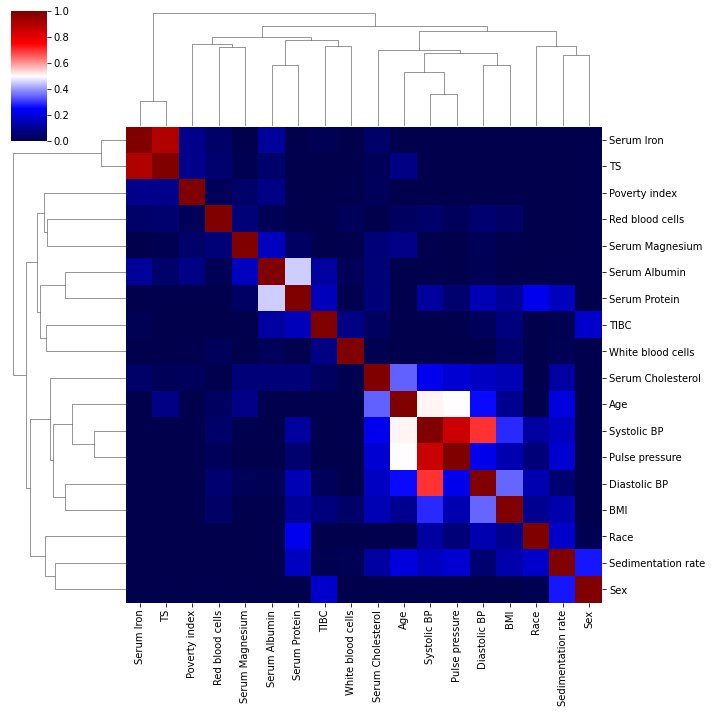

In [15]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=0)

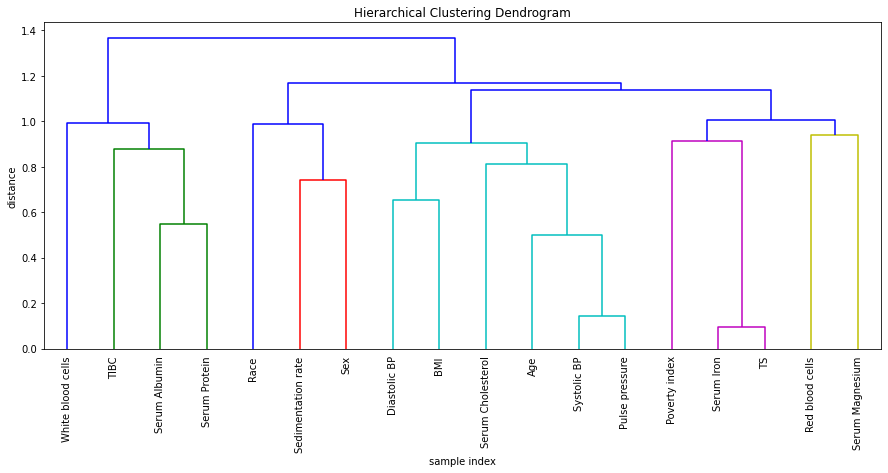

In [22]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

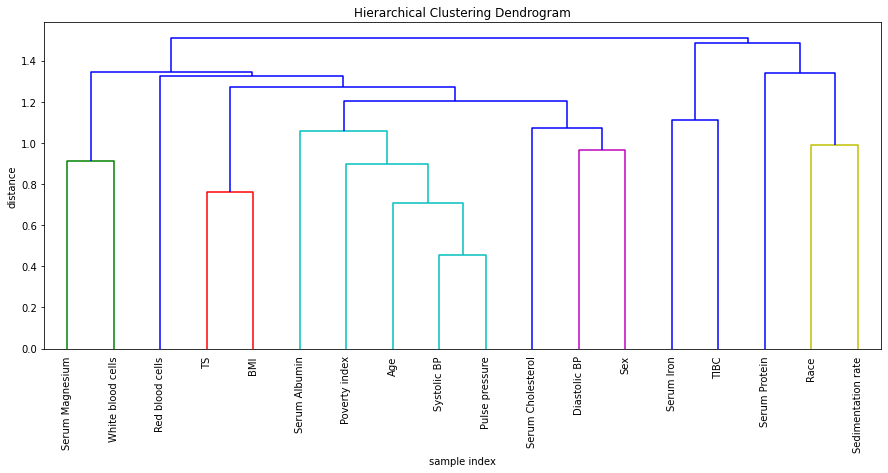

In [30]:
cluster_matrix_shap = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix_shap,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

In [26]:
E = GraphExplainer(graph, X)
E.prepare_graph(X[:nsamples])
cf_h = CreditFlow(hcluster_graph(E.graph, list(X.columns), cluster_matrix), nruns=100)
cf_h.run()


sampling: 100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


In [ ]:
cf_h.draw(max_display=20)

# incorporate causal relationship

In [34]:
X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [54]:
def build_graph(model, X, display_translator={}, target_name='prediction'):
    '''
    build and return a graph (list of nodes), to be runnable in main
    model: xgboost model
    X: background distribution (n, d) dataframe object
    x: target samples to be explained (n2, d)
    names: the feature names of the d dimensional features
    display_translator: translate features values to readable format, see flow.py:translator
    '''
    categorical_features = ['Race', 'Sex']
    
    def create_f(parents, m):
        def f_(*args):
            bs = len(args[0])
            o = m.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((n.name, args[i]) for i, n in enumerate(parents)))))
            if len(o) != bs: # discrete case
                o = o.reshape(bs, -1)
            return o
        return f_

    # build the graph
    names = list(X.columns)
    
    # note the ancestor and other nodes and sort according to names order
    A = ['Age', 'Sex', 'Poverty index', 'Race']
    D = list(set(names) - set(A))
    A = sorted(A, key=lambda x: names.index(x))
    D = sorted(D, key=lambda x: names.index(x))
    
    nodes = []
    nodes_A = []
    nodes_D = []
    for name in A:
        node = Node(name)
        nodes.append(node)
        nodes_A.append(node)

    pbar = tqdm.tqdm(list(enumerate(D)))
    for i, name in pbar:
        pbar.set_description(f'learning dependency for {name}')
        parents = nodes_A
        
        # learn a new model here
        X_train, X_test, y_train, y_test = train_test_split(X[[p.name for p in parents]], np.array(X[name]), test_size=0.2, random_state=7)
        xgb_train = xgboost.DMatrix(X_train, label=y_train)
        xgb_test = xgboost.DMatrix(X_test, label=y_test)
        
        if name in categorical_features:
            
            num_class = len(np.unique(X[name]))
            params = {
                "eta": 0.002,
                "max_depth": 3,
                'objective': 'multi:softprob',
                'eval_metric': 'mlogloss',
                'num_class': num_class,
                "subsample": 0.5
            }
        else:
            params = {
                "eta": 0.002,
                "max_depth": 3,
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                "subsample": 0.5
            }
        m = xgboost.train(params, xgb_train, 500, evals = [(xgb_test, "test")], verbose_eval=100) #False)
            
        # use the new model:
        node = Node(name, 
                    create_f(parents, m), 
                    parents)
        nodes_D.append(node)
        nodes.append(node)
    
    parents = sorted(nodes_A + nodes_D, key=lambda x: names.index(x.name))
    nodes.append(Node(target_name, 
                      create_f(parents, model), 
                      parents, is_target_node=True))
    
    graph = Graph(nodes, display_translator=display_translator)
    return graph
    
nsamples = 1000
graph = build_graph(model, X.fillna(X.mean()), translator(X.columns, X, X_display), 'predicted hazard')


learning dependency for Diastolic BP:   0%|          | 0/14 [00:00<?, ?it/s]

[0]	test-rmse:83.45434
[100]	test-rmse:68.65943
[200]	test-rmse:56.62569
[300]	test-rmse:46.86730
[400]	test-rmse:38.98175
[499]	test-rmse:32.70708



learning dependency for Red blood cells:   7%|▋         | 1/14 [00:00<00:08,  1.52it/s]

[0]	test-rmse:56.20642
[100]	test-rmse:46.76483
[200]	test-rmse:39.18215
[300]	test-rmse:33.14611
[400]	test-rmse:28.39700
[499]	test-rmse:24.73910



learning dependency for Sedimentation rate:  14%|█▍        | 2/14 [00:01<00:07,  1.56it/s]

[0]	test-rmse:19.06218
[100]	test-rmse:16.63553
[200]	test-rmse:14.78646
[300]	test-rmse:13.40350
[400]	test-rmse:12.38542
[499]	test-rmse:11.65269



learning dependency for Serum Albumin:  21%|██▏       | 3/14 [00:02<00:07,  1.46it/s]     

[0]	test-rmse:3.87332
[100]	test-rmse:3.17657
[200]	test-rmse:2.60711
[300]	test-rmse:2.14223
[400]	test-rmse:1.76347
[499]	test-rmse:1.45796



learning dependency for Serum Cholesterol:  29%|██▊       | 4/14 [00:02<00:06,  1.48it/s]

[0]	test-rmse:224.96176
[100]	test-rmse:185.94234
[200]	test-rmse:154.38560
[300]	test-rmse:128.99480
[400]	test-rmse:108.68519
[499]	test-rmse:92.74993



learning dependency for Serum Iron:  36%|███▌      | 5/14 [00:03<00:06,  1.48it/s]       

[0]	test-rmse:106.63545
[100]	test-rmse:89.76170
[200]	test-rmse:76.42320
[300]	test-rmse:66.02176
[400]	test-rmse:58.04936
[499]	test-rmse:52.11069



learning dependency for Serum Magnesium:  43%|████▎     | 6/14 [00:04<00:05,  1.51it/s]

[0]	test-rmse:1.18048
[100]	test-rmse:0.96824
[200]	test-rmse:0.79528
[300]	test-rmse:0.65462
[400]	test-rmse:0.54071
[499]	test-rmse:0.44964



learning dependency for Serum Protein:  50%|█████     | 7/14 [00:04<00:04,  1.63it/s]  

[0]	test-rmse:6.60888
[100]	test-rmse:5.41767
[200]	test-rmse:4.44389
[300]	test-rmse:3.64885
[400]	test-rmse:3.00054
[499]	test-rmse:2.47715



learning dependency for Systolic BP:  57%|█████▋    | 8/14 [00:04<00:03,  1.75it/s]  

[0]	test-rmse:136.35716
[100]	test-rmse:112.38604
[200]	test-rmse:92.87887
[300]	test-rmse:77.07088
[400]	test-rmse:64.31760
[499]	test-rmse:54.17580



learning dependency for TIBC:  64%|██████▍   | 9/14 [00:05<00:02,  1.71it/s]       

[0]	test-rmse:366.99554
[100]	test-rmse:302.33221
[200]	test-rmse:249.75769
[300]	test-rmse:207.16592
[400]	test-rmse:172.80176
[499]	test-rmse:145.52786



learning dependency for TS:  71%|███████▏  | 10/14 [00:06<00:02,  1.71it/s]  

[0]	test-rmse:29.96921
[100]	test-rmse:25.30479
[200]	test-rmse:21.63165
[300]	test-rmse:18.77836
[400]	test-rmse:16.60428
[499]	test-rmse:14.99358



learning dependency for White blood cells:  79%|███████▊  | 11/14 [00:06<00:01,  1.74it/s]

[0]	test-rmse:7.22900
[100]	test-rmse:6.02983
[200]	test-rmse:5.07068
[300]	test-rmse:4.31042
[400]	test-rmse:3.71581
[499]	test-rmse:3.26117



learning dependency for BMI:  86%|████████▌ | 12/14 [00:07<00:01,  1.66it/s]              

[0]	test-rmse:25.48025
[100]	test-rmse:21.02089
[200]	test-rmse:17.40844
[300]	test-rmse:14.49518
[400]	test-rmse:12.16237
[499]	test-rmse:10.32634



learning dependency for Pulse pressure:  93%|█████████▎| 13/14 [00:08<00:00,  1.64it/s]

[0]	test-rmse:54.40375
[100]	test-rmse:45.56836
[200]	test-rmse:38.48766
[300]	test-rmse:32.87592
[400]	test-rmse:28.48240
[499]	test-rmse:25.11006



learning dependency for Pulse pressure: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


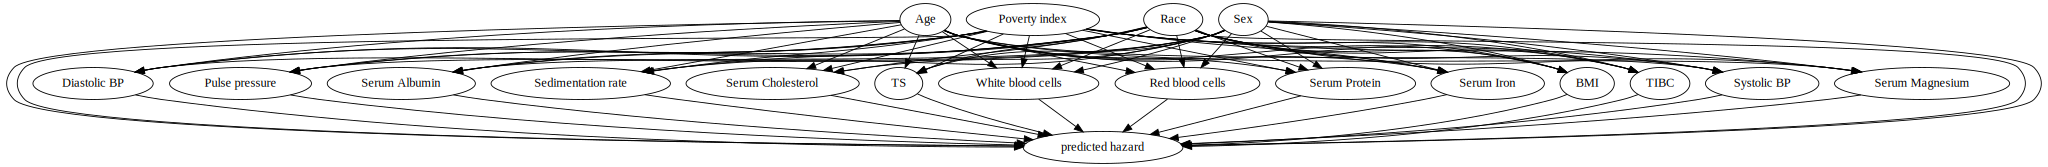

In [55]:
graph.draw()

In [56]:
cf_o = GraphExplainer(graph, X, nruns=30).shap_values(X[:nsamples])


sampling: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


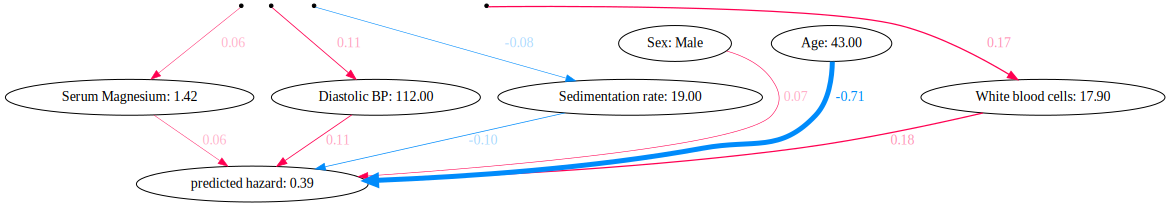

In [70]:
sample_ind = 66
cf_o.fold_noise = True
cf_o.draw(idx=sample_ind, max_display=10)

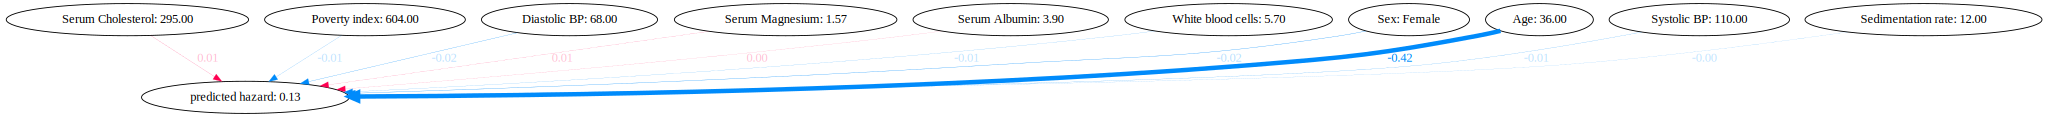

In [65]:
cf.draw(idx=sample_ind, max_display=10)

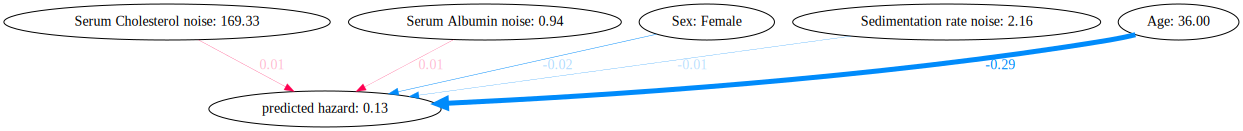

In [66]:
cf_o.fold_noise = False
cf_o.draw_asv(sample_ind, max_display=5)